
--- Contents of folder ANTL5770C8970_cleaned ---
    ANTL5770C8970_cleaned_S1_2025-05-01.jpg
    ANTL5770C8970_cleaned_S1_2025-05-01.tif
    ANTL5770C8970_cleaned_S2_2025-05-01.jpg
    ANTL5770C8970_cleaned_S2_2025-05-01.tif
    ANTL5770C8970_cleaned_lidar.tif
    ANTL5770C8970_cleaned_lidar_hillshade.jpg


/tmp/ipykernel_106/4157260300.py:42: RuntimeWarning: invalid value encountered in cast
  return (np.clip(hs, 0, 1) * 255).astype("uint8")


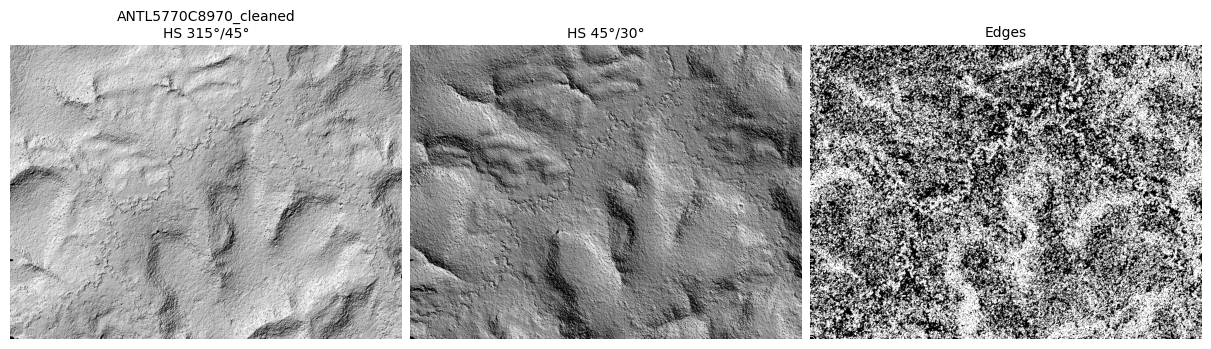

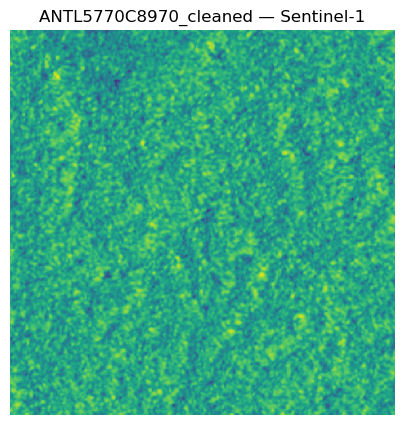

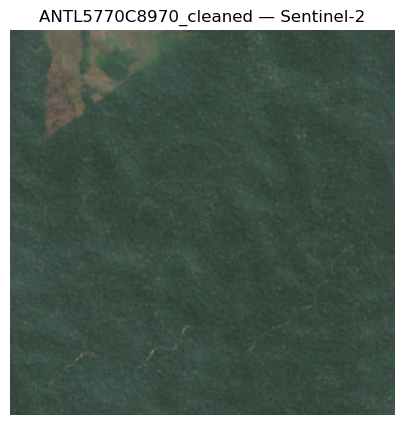

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-*******************************************************************************************************************************************************KowA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [1]:
import os
import csv
import base64
import textwrap
import yaml
from pathlib import Path

import numpy as np
import rasterio
from openai import OpenAI
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# ─────────────────────────── Load environment and config ───────────────────────────
load_dotenv()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Directory where predicted tile folders live
PREDICTED_DIR = Path(config["results_dir"]) / os.getenv("PREDICTED_SUBDIR", "predicted")
# Date string for Earth observation imagery
DATE_TO_DOWNLOAD = os.getenv("GE_DATE", "2025-05-01")
# OpenAI credentials and model
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
VISION_MODEL   = os.getenv("VISION_MODEL", "gpt-4.1")

if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY is not set in the environment")

client = OpenAI(api_key=OPENAI_API_KEY)

# ───────────────────────── Helper functions ─────────────────────────
def compute_hillshade(dtm: np.ndarray, azimuth: float, altitude: float) -> np.ndarray:
    az = np.deg2rad(azimuth)
    alt = np.deg2rad(altitude)
    dy, dx = np.gradient(dtm.astype("float32"))
    slope  = np.arctan(np.hypot(dx, dy))
    aspect = np.arctan2(dy, -dx)
    hs = (np.sin(alt) * np.cos(slope) +
          np.cos(alt) * np.sin(slope) * np.cos(az - aspect))
    return (np.clip(hs, 0, 1) * 255).astype("uint8")


def visualize_lidar_triptych(tif_path: Path, title: str = ""):
    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype("float32")
        nod = src.nodata
        if nod is not None:
            arr[arr == nod] = np.nan

    hs1 = compute_hillshade(arr, azimuth=315, altitude=45)
    hs2 = compute_hillshade(arr, azimuth=45,  altitude=30)
    dy, dx = np.gradient(hs1.astype("float32"))
    edges = (np.hypot(dx, dy) >= 20).astype("uint8") * 255

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axes[0].imshow(hs1, cmap="gray", origin="upper")
    axes[0].set_title(f"{title}\nHS 315°/45°", fontsize=10)
    axes[0].axis('off')
    axes[1].imshow(hs2, cmap="gray", origin="upper")
    axes[1].set_title("HS 45°/30°", fontsize=10)
    axes[1].axis('off')
    axes[2].imshow(edges, cmap="gray", origin="upper")
    axes[2].set_title("Edges", fontsize=10)
    axes[2].axis('off')
    plt.show()
    plt.close(fig)


def visualize_image(path: Path, title: str = None):
    img = Image.open(path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


def describe_triplet_with_vision(paths, prompt_text):
    messages = [{"type": "text", "text": prompt_text}]
    for p in paths:
        with open(p, "rb") as f:
            b64 = base64.b64encode(f.read()).decode()
        messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpg;base64,{b64}"}
        })
    resp = client.chat.completions.create(
        model=VISION_MODEL,
        messages=[{"role": "user", "content": messages}],
        temperature=0
    )
    return resp.choices[0].message.content.strip()

COMBINED_PROMPT = textwrap.dedent(f"""
You are an expert in verifying archaeological features via remote sensing. Below are three co-registered images of the same area (date: {DATE_TO_DOWNLOAD}):

1) LiDAR hillshade composite (two sun angles + edge gradient)
2) Sentinel-1 SAR (VV)
3) Sentinel-2 true-color

Previously an ML model flagged this tile as an archaeological site. Your task is to verify **only what is visible**, without speculation.

Answer format:
[YES] if you clearly see a man-made earth structure (enclosure, mound, ditch, geoglyph) that:
 • has closed or linear geometry,
 • appears in all three images,
 • cannot be explained by roads, fields or natural erosion.

[NO] otherwise.

After the tag, include:
1) **Observation**: describe 1–2 concrete patterns seen in each image.
2) **Reasoning**: explain why these features exclude modern/natural causes.
3) **Uncertainty**: if any image is too noisy, note “Uncertain on [S1/S2] due to …” and default to NO.

If you lack direct access to the image, state this fact instead of guessing.
"""
)

# ───────────────────────── Main block ─────────────────────────
results = []
for tile_dir in sorted(PREDICTED_DIR.iterdir()):
    if not tile_dir.is_dir():
        continue
    name = tile_dir.name

    print(f"\n--- Contents of folder {name} ---")
    for f in sorted(tile_dir.iterdir()):
        print("   ", f.name)

    lidar_tif = tile_dir / f"{name}_lidar.tif"
    lidar_jpg = tile_dir / f"{name}_lidar_hillshade_contrast.jpg"
    if not lidar_jpg.exists():
        lidar_jpg = tile_dir / f"{name}_lidar_hillshade.jpg"

    p_s1 = tile_dir / f"{name}_S1_{DATE_TO_DOWNLOAD}.jpg"
    p_s2 = tile_dir / f"{name}_S2_{DATE_TO_DOWNLOAD}.jpg"

    rec = {"tile": name}
    if lidar_tif.exists() and lidar_jpg.exists() and p_s1.exists() and p_s2.exists():
        visualize_lidar_triptych(lidar_tif, title=name)
        visualize_image(p_s1, f"{name} — Sentinel-1")
        visualize_image(p_s2, f"{name} — Sentinel-2")

        rec["vision_verification"] = describe_triplet_with_vision(
            [lidar_jpg, p_s1, p_s2],
            COMBINED_PROMPT
        )
    else:
        rec["vision_verification"] = "MISSING_IMAGE"

    print(f"[{name}] -> {rec['vision_verification']}")
    results.append(rec)

out_csv = PREDICTED_DIR / "vision_verification.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["tile", "vision_verification"])
    writer.writeheader()
    writer.writerows(results)

print(f"\nDone! Results saved to: {out_csv}")